# Topic Modeling Clustering

In this notebook we visualize a previously generated topic model.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np

## Configuration

In [2]:
data_prefix = 'jstor_hyperparameter'
db_dir = './db'

In [3]:
data_prefix

'jstor_hyperparameter'

## Import Topic Data

We import our previously generated model.

In [4]:
topic_model_suffix = '_NMF'
# topic_model_suffix = ''

In [5]:
LABELS = pd.read_csv(f"{db_dir}/{data_prefix}-LABELS.csv").set_index('doc_id')
VOCAB = pd.read_csv(f"{db_dir}/{data_prefix}-VOCAB.csv").set_index('term_str')
BOW = pd.read_csv(f"{db_dir}/{data_prefix}-BOW.csv").set_index(['doc_id','term_str'])
TOPICS = pd.read_csv(f"{db_dir}/{data_prefix}-TOPICS{topic_model_suffix}.csv").set_index('topic_id')
THETA = pd.read_csv(f"{db_dir}/{data_prefix}-THETA{topic_model_suffix}.csv").set_index('doc_id')
THETA.columns.name = 'topic_id'
THETA.columns = [int(col) for col in THETA.columns] # Should change columns to strings
PHI = pd.read_csv(f"{db_dir}/{data_prefix}-PHI{topic_model_suffix}.csv").set_index('topic_id')
PHI.columns.name = 'term_str'

In [6]:
n_topics = len(TOPICS)
topic_cols = [t for t in range(n_topics)]

# Inspect Results

## Sort Topics by Doc Weight

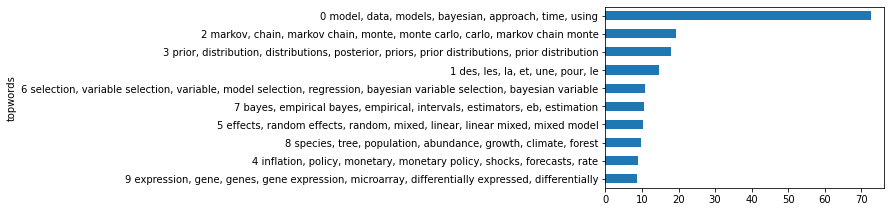

In [7]:
TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, n_topics/3), legend=False);

## Clutser Topics

In [8]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [9]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, n_topics / 3))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [29]:
SIMS = pdist(normalize(PHI), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

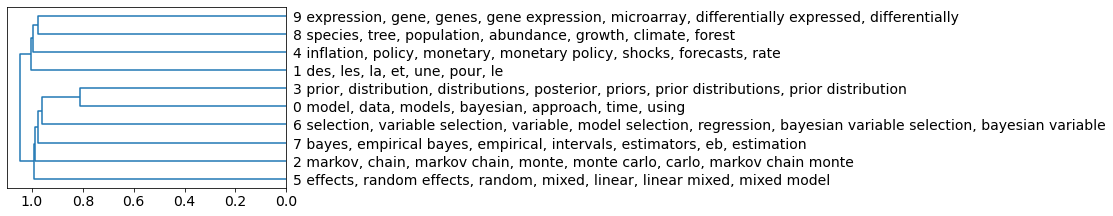

In [30]:
plot_tree(TREE, TOPICS.topwords.to_list());

## Group Topics by Label

In [12]:
LABELS.columns

Index(['doc_title', 'doc_url', 'doc_lang', 'doc_srccat', 'doc_year',
       'doc_date', 'doc_tdmcat'],
      dtype='object')

In [13]:
# group_col = 'doc_label'
group_col = 'doc_srccat'

In [14]:
group_vals = LABELS[group_col].value_counts().to_frame('n')
group_vals.index.name = 'group_id'

In [15]:
group_vals

,n
group_id,
"['Science & Mathematics', 'Statistics']",657
"['Mathematics', 'Science & Mathematics', 'Statistics']",99
"['Science and Mathematics', 'Statistics']",78
"['Science & Mathematics', 'Computer Science', 'Statistics']",60
"['Business & Economics', 'Business', 'Economics']",60
...,...
"['Marketing & Advertising', 'Business & Economics']",1
"['Peace & Conflict Studies', 'Political Science', 'Social Sciences']",1
"['Biological Sciences', 'General Science', 'Science and Mathematics']",1


In [16]:
# group_vals.sort_values('n').plot.barh(figsize=(5,len(group_vals) / 3), legend=False);

In [17]:
G = THETA.join(LABELS).groupby(group_col)[topic_cols].mean()
G.index.name = 'group_id'
G.columns = TOPICS.topwords

### Heatmap of Labels and Topics

In [31]:
# G.style.background_gradient()

### Top Topic per Label Group

In [32]:
group_vals['top_topic'] = G.T[group_vals.index].idxmax()

In [33]:
group_vals.sort_values('top_topic')

,n,top_topic
group_id,,
"['Science & Mathematics', 'Statistics']",657,"0 model, data, models, bayesian, approach, tim..."
"['General Science', 'Mathematics', 'Science and Mathematics']",4,"0 model, data, models, bayesian, approach, tim..."
"['Business & Economics Collection', 'Economics']",3,"0 model, data, models, bayesian, approach, tim..."
"['Science & Mathematics', 'Biological Sciences', 'Medicine & Allied Health', 'Health Sciences']",3,"0 model, data, models, bayesian, approach, tim..."
"['Management & Organizational Behavior', 'Business & Economics', 'Business']",2,"0 model, data, models, bayesian, approach, tim..."
...,...,...
"['Biological Sciences', 'Ecology & Evolutionary Biology', 'Science and Mathematics']",12,"8 species, tree, population, abundance, growth..."
"['Science & Mathematics', 'Environmental Science']",3,"8 species, tree, population, abundance, growth..."
"['Ecology & Evolutionary Biology', 'Science & Mathematics', 'Biological Sciences']",54,"8 species, tree, population, abundance, growth..."


### Top Label Group per Topic

In [34]:
G.idxmax().to_frame('label').sort_values('label')

,label
topwords,
"8 species, tree, population, abundance, growth, climate, forest","['Biological Sciences', 'Ecology & Evolutionar..."
"4 inflation, policy, monetary, monetary policy, shocks, forecasts, rate","['Business & Economics', 'Business', 'Economic..."
"1 des, les, la, et, une, pour, le","['Business & Economics', 'Mathematics', 'Scien..."
"2 markov, chain, markov chain, monte, monte carlo, carlo, markov chain monte","['Ecology & Evolutionary Biology', 'Science & ..."
"5 effects, random effects, random, mixed, linear, linear mixed, mixed model","['Science & Mathematics', 'Biological Sciences..."
"6 selection, variable selection, variable, model selection, regression, bayesian variable selection, bayesian variable","['Science & Mathematics', 'Biological Sciences..."
"9 expression, gene, genes, gene expression, microarray, differentially expressed, differentially","['Science & Mathematics', 'Botany & Plant Scie..."
"0 model, data, models, bayesian, approach, time, using","['Science & Mathematics', 'Mathematics', 'Gene..."
"3 prior, distribution, distributions, posterior, priors, prior distributions, prior distribution","['Science & Mathematics', 'Mathematics', 'Stat..."
